# Grant Classification
## Data Analysis and Preprocessing

In [1]:
%matplotlib inline

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes, svm, linear_model
from sklearn.metrics import accuracy_score

import xgboost
from gensim.models import Word2Vec, KeyedVectors
plt.style.use('ggplot')

np.random.seed(359)  # reproducibility

## Examining the data

In [4]:
data = pd.read_excel(io="../data/data2020.xlsx",
                     usecols=['Politikbereich', 'Zweck'])

In [72]:
print("Missing predictors:", len(data[data["Zweck"].isna()]))
print("Missing targets:", len(data[data["Politikbereich"].isna()]))

Missing predictors: 0
Missing targets: 0


In [74]:
data[['Zweck', 'Politikbereich']].head(10)

,Zweck,Politikbereich
0,"Nord-Süd-Tangente; Linie 26/27, 2.2. Teil-BPU,A",Verkehr
1,Zusammen Fit für die Schule – Projekt zur Förd...,Integration
2,Kontakt- und Beratungsstelle/SleepIn (KuB),Jugend
3,Gute-Kita-Gesetz- Ausgestaltung pädagogischer ...,Jugend
4,Ausstellungen Schöner Strom/Einzug der Elektri...,Kultur
5,Personal- und Sachkosten für Öffentlichkeitsar...,Wirtschaft
6,Ladeinfrastruktur,Wirtschaft
7,APG 0920-68406-353 / Projektnr. APG-MH/1-2020...,Gesundheit
8,Radfahrtrainings für geflüchtete Frauen,Verkehr
9,Errichtung einer Betriebsstätte,Wirtschaft


## Preprocessing the Text

The data lies in several .xlsx files divided by their year of issuing. We are going to examine data only from the past year, as to reduce loading and training times. At best all data should be examined (or a stratified sample of the years if there are deviations in the distribution)

We are going to be using spacy for text preprocessing. The German module of spacy should be first downloaded on your machine (python -m spacy download de).

We are using the stopwords from the space module and not from another one (like nltk). Because spacy offers a lot more (among them some that might be useful), but overall the expectation is for longer, more specific words in the purpose description to carry more meaning.

In [3]:
de = spacy.load('de_core_news_sm')
stopwords = de.Defaults.stop_words

In [69]:
umlauts = {'ä': 'ae', 'ö': 'oe', 'ü': 'ue'}

Data preprocessing proceeds as follows:
1. We remove punctuation
2. We remove digits
3. Extra spaces are trimmed
4. Special characters in the German alphabet are replaced
5. We lowercase all text
6. We lemmatize all words using spacy
7. Stop words are filtered
8. Words are concatenated abck together into sentences (easier to work with)

In [5]:
data['Zweck_clean'] = data['Zweck'].str.replace('[^\w\s]+', ' ', regex=True) \
                             .str.replace('\d+', ' ', regex=True) \
                             .str.replace(' +', ' ', regex=True) \
                             .replace(umlauts, regex=True) \
                             .str.lower() \
                             .apply(lambda x: [word.lemma_ for word in de(str(x))]) \
                             .apply(lambda x: [item for item in x if item not in stopwords]) \
                             .str.join(' ')

In [28]:
data['Zweck'].head(10)

0      Nord-Süd-Tangente; Linie 26/27, 2.2. Teil-BPU,A
1    Zusammen Fit für die Schule – Projekt zur Förd...
2           Kontakt- und Beratungsstelle/SleepIn (KuB)
3    Gute-Kita-Gesetz- Ausgestaltung pädagogischer ...
4    Ausstellungen Schöner Strom/Einzug der Elektri...
5    Personal- und Sachkosten für Öffentlichkeitsar...
6                                    Ladeinfrastruktur
7    APG 0920-68406-353 / Projektnr.  APG-MH/1-2020...
8              Radfahrtrainings für geflüchtete Frauen
9                      Errichtung einer Betriebsstätte
Name: Zweck, dtype: object

In [6]:
data['Zweck_clean'].head(10)

0                         nord sued tangente linie bpu
1    fit fuer schule projekt foerderung sprachentwi...
2                  kontakt beratungsstelle sleepin kub
3    kita gesetz ausgestaltung paedagogischer raeum...
4    ausstellungen schoener strom einzug elektrizit...
5    personal sachkosten fuer öffentlichkeitsarbeit...
6                                    ladeinfrastruktur
7       apg projektnr apg mh projekt janz nah draussen
8            radfahrtrainings fuer gefluechtete frauen
9                           errichtung betriebsstaette
Name: Zweck_clean, dtype: object

We then remove categories with single data point representation (to make working with stratified sampes easier, but they also don't carry much meaning for the model)

We create our train/test split and encode the outcome as numbers.

In [8]:
data = data.groupby('Politikbereich').filter(lambda x: len(x) > 1)  # TODO: use in prod
train_X, test_X, train_y, test_y = train_test_split(data['Zweck_clean'], 
                                                    data['Politikbereich'], 
                                                    test_size=0.2,
                                                    stratify=data['Politikbereich'])

encoder = LabelEncoder()
encoder = encoder.fit(data['Politikbereich'])
train_y_enc = encoder.transform(train_y)
test_y_enc = encoder.transform(test_y)

There are several vectorisation techniques we could use. We are going to start off with tfidf.

Word2Vec should be examined afterwards and as it preserves more meaning, the expectation would be for it to yield better results.

In [9]:
Tfidf_vect = TfidfVectorizer(max_features=500)  # TOD: play with that
Tfidf_vect.fit(data['Zweck_clean'])
train_X_tfidf = Tfidf_vect.transform(train_X)
test_X_tfidf = Tfidf_vect.transform(test_X)

## Analysing the data

We have our data ready for the models to consume. We have to, however, first see what we are working with.

In [ ]:
print("Size of sample data:", len(data))

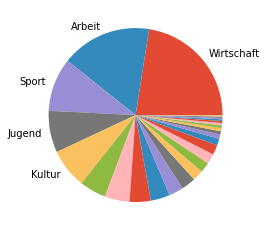

Most prevalent class %: 22.5
10 least prevalent classes %: 2.4


In [68]:
cat_distr = data.Politikbereich.value_counts()
plt.pie(cat_distr, labels=(list(cat_distr.index[:5]) + ['']*(len(cat_distr)-5)))
plt.show()

print("Most prevalent class %:", round(cat_distr[0]/len(data), 3)*100)
print("10 least prevalent classes %:", round(sum(cat_distr[-10:])/len(data), 3)*100)

We see that our data is heavily imbalanced, which we have to have in mind when going to the modelling step.

Upon further inspection we also see a useful pattern in one of the classes:

In [58]:
data[data['Politikbereich'] == 'Sport']['Zweck'].head(10)

11       Kosten für die Beschäftigung von Übungsleitern
12    Schaffung besserer Trainingsbedingungen für di...
15       Kosten für die Beschäftigung von Übungsleitern
16       Kosten für die Beschäftigung von Übungsleitern
17    Kosten für die Beschäftigung von hauptberuflic...
18    Kosten für die Beschäftigung von hauptberuflic...
19       Kosten für die Beschäftigung von Übungsleitern
20       Kosten für die Beschäftigung von Übungsleitern
21       Kosten für die Beschäftigung von Übungsleitern
22                         Sondermittelantrag Nummer  2
Name: Zweck, dtype: object

In [60]:
sport_pattern = data[data['Zweck'].str.contains("Kosten für die Beschäftigung")]['Politikbereich']
print("Categories in pattern:", sport_pattern.unique())
print("Size of pattern:", sport_pattern.shape[0])

Categories in pattern: ['Sport']
Size of pattern: 692


By analyzing the data, we could implement manual rules in order to help out our models as more than 5% of our sample matches with it.

## Unfinished:

#### Testing a Word2Vec Version

Using word2vec and computing the mean of the participating vectors.
Doc2Vec implementations should be considered.

In [12]:
model = KeyedVectors.load_word2vec_format('/Users/boris/Downloads/german.model', binary=True)

In [13]:
train_X

3765     unterstuetzung aufbauphase existenzgruendungen...
7453     herstellungstechnologien replizierten stark ge...
7439         lohnkostenzuschuss fuer blueprint berlin gmbh
8466                        stadt kiez schule zeig zukunft
5953     bezirkliche stadtteilkoordination sicherung st...
                               ...                        
7636       frei raeume fuer maedchen junge frauen weiß ...
4359     ergaenzung streetwork aufsuchend jugendsoziala...
10027                             arbeitsintegration aktiv
7910                                           plug hybrid
5092     ehap ii aha ehap beratung reinickendorf foerde...
Name: Zweck_clean, Length: 9015, dtype: object

In [14]:
model.most_similar(positive=['Koenig', 'Frau'], negative=['Mann'])

[('Koenigin', 0.7524535655975342),
 ('Prinzessin', 0.7145279049873352),
 ('Prinz', 0.6881615519523621),
 ('Jungschuetzenkoenigin', 0.6740390658378601),
 ('Majestaet', 0.6590647101402283),
 ('Kronprinz_Philippe', 0.6576778292655945),
 ('Regentin', 0.6576672196388245),
 ('Prinzen', 0.6576202511787415),
 ('Carl_XVI', 0.6540848612785339),
 ('Prinzessin_Maxima', 0.6527888774871826)]

In [15]:
my_dict = dict({})
for idx, key in enumerate(model.index_to_key):
    my_dict[key] = model.get_vector(key)

In [31]:
def vectorize(X):
    vecs = np.array([])
    for words in X:
        mean_vec = np.array([])
        for w in words:
            if w in my_dict:
                np.append(mean_vec, my_dict[w], axis = 0)
            elif w.capitalize() in my_dict:
                np.append(mean_vec, my_dict[w.capitalize()], axis = 0)
            else:
                np.append(mean_vec, np.zeros(300), axis = 0)       
            
        np.append(vecs, np.mean(mean_vec, axis=0), axis = 0)
        
        
    return vecs

In [32]:
Train_X_Word2Vec = vectorize(train_X)
Test_X_Word2Vec = vectorize(test_X)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [30]:
Train_X_Word2Vec

array([], dtype=float64)